In [1]:
import mne
mne.set_log_level('error')
import matplotlib
import matplotlib.pyplot as plt
from functions import *
from autoreject import get_rejection_threshold
#matplotlib.use('TkAgg')

### Load the data

#### Bruk denne på egen pc

In [2]:
data_path = "/Users/sunniva/Documents/Prosjektoppgave/Data Set Alcohol Detector/Subjects"
p_id = "/" + "sub-P019" + "/" + "ses-S002" + "/" + "sub-P019_ses-S002_task-Default_run-005"
raw = mne.io.read_raw_fif(data_path + "/" + p_id + "_eeg.fif", preload=True)

#### Bruk denne på skole-pc

In [3]:
data_path = "/Users\sunnivlf\Documents/Data Set Alcohol Detector/Subjects" # Load this from where you have saved it on your computer
p_id = "/" + "sub-P019" + "/" + "ses-S002" + "/" + "sub-P019_ses-S002_task-Default_run-005"
raw = mne.io.read_raw_fif(data_path + "/" + p_id + "_eeg.fif", preload=True)

FileNotFoundError: fname does not exist: "/Users\sunnivlf\Documents/Data Set Alcohol Detector/Subjects/sub-P019/ses-S002/sub-P019_ses-S002_task-Default_run-005_eeg.fif"

### ICA filtering

In [5]:
# Filter settings
ica_low_cut = 1.0       # ICA is sensitive to low-frequency drifts and therefore requires the data to be high-pass filtered prior to fitting. Typically, a cutoff frequency of 1 Hz is recommended.
ica_hi_cut  = 30

raw_ica = raw.copy().filter(ica_low_cut, ica_hi_cut)

### Segment data for ICA

In [6]:
# Break raw data into 1s epochs
tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

reject = get_rejection_threshold(epochs_ica);
reject

Estimating rejection dictionary for eeg


{'eeg': 0.0002689046069684262}

### Fit ICA to data

In [7]:
# ICA parameters
random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica,
        reject=reject,
        tstep=tstep)

Method,fastica
Fit,27 iterations on epochs (108181 samples)
ICA components,7
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


### Visualiza ICA components

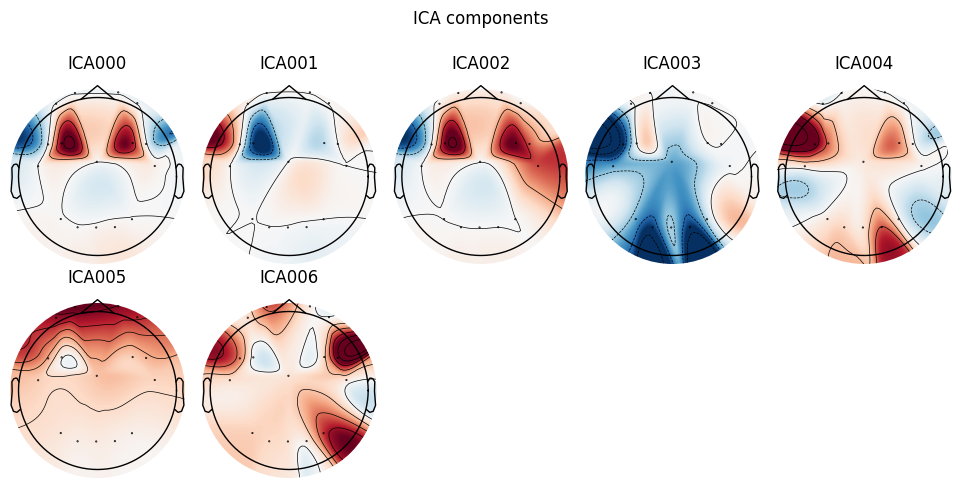

In [8]:
ica.plot_components();

### Identify EOG artifacts from ICA components

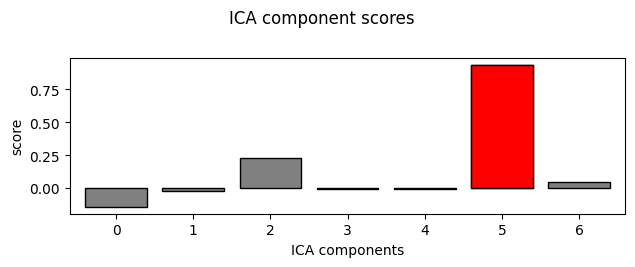

In [9]:
ica_z_thresh = 1.96 
eog_indices, eog_scores = ica.find_bads_eog(raw_ica, 
                                            ch_name=['Fp2'], 
                                            threshold=ica_z_thresh)
ica.exclude = eog_indices
ica.plot_scores(eog_scores);
# ica.apply(raw.copy())

### Save the ICA

In [11]:
#data_path = "/Users\sunnivlf\Documents/Preprocessed data" ## Save this somewhere on your own computer
data_path = "/Users/sunniva/Documents/TTK7 Adaptive Data Analysis/TTK7-project2" ## Save this somewhere on your own computer
ica.save(data_path + '/' + p_id + '-ica.fif', 
        overwrite=True);

### ERP epochs

In [ ]:
low_cut = 0.1 
hi_cut  = 45
raw_filt = raw.copy().notch_filter([50], method='iir').filter(low_cut, hi_cut)

In [ ]:
event_dict = {
    "Cross presented" : 49,
    "Congruent stimulus presented" : 50,
    "Incongruent stimulus presented" : 51,
    "Break between blocks" : 52,
    "Flanker task started" : 53,
    "Flanker task ended" : 54,
    "A-key pressed" : 55,
    "L-key pressed" : 56,
}

[[2109    0   53]
 [2359    0   49]
 [2864    0   51]
 [3061    0   56]
 [3369    0   49]
 [3874    0   50]
 [4014    0   56]
 [4378    0   49]
 [4883    0   50]
 [5004    0   55]]


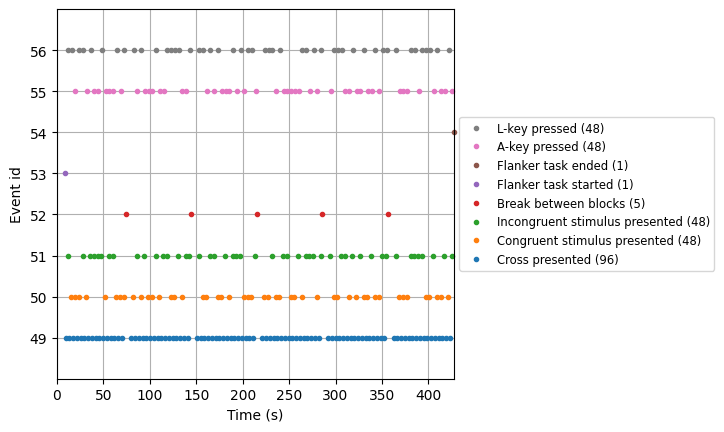

In [ ]:
events = mne.find_events(raw_filt)
print(events[:10])  # show the first 5
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw_filt.info["sfreq"], first_samp=raw_filt.first_samp
)

In [ ]:
# Epoching settings
tmin =  -.200  # start of each epoch (in sec)
tmax =  1.000  # end of each epoch (in sec)
baseline = (tmin, 0)

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_dict,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True
                   ) 

epochs

Number of events,295
Events,A-key pressed: 48Break between blocks: 5Congruent stimulus presented: 48Cross presented: 96Flanker task ended: 1Flanker task started: 1Incongruent stimulus presented: 48L-key pressed: 48
Time range,-0.200 – 1.000 s
Baseline,-0.200 – 0.000 s


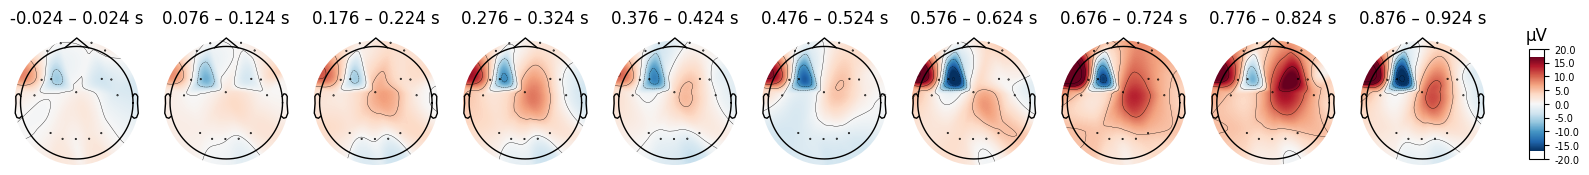

In [ ]:
evoked = epochs.average()
times = np.arange(0, tmax, 0.1)
evoked.plot_topomap(times=times, average=0.050);

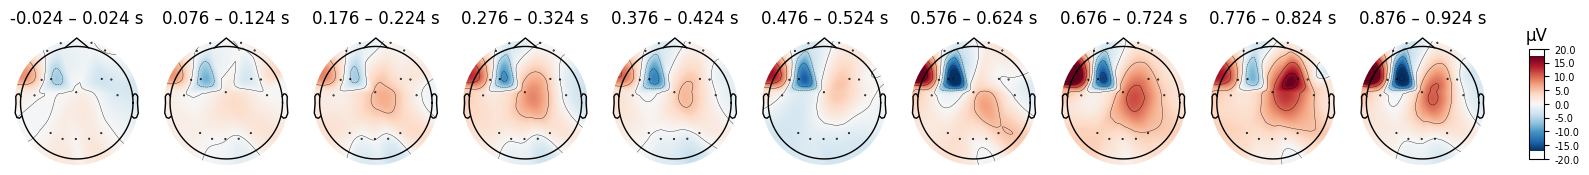

In [ ]:
epochs_postica = ica.apply(epochs.copy())
evoked_postica = epochs_postica.average()
evoked_postica.plot_topomap(times=times, average=0.050);